<a href="https://colab.research.google.com/github/Farmhouse121/Financial-Data-Science-in-Python/blob/main/Equity_Correlation_without_Factors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Index Pairwise Correlations
---
### Initialize the Workspace
This is done by bringing in a standard library package, which you can find here [my_library.py](https://github.com/Farmhouse121/Financial-Data-Science-in-Python/blob/main/my_library.py). This needs to be imported into the workspace of the project, and then executed. For brevity, we also turn off `UserWarning` and `FutureWarning`. You can skip that step if you want to.

In [ ]:
from my_library import *

12:27:04 Starting...
12:27:04 Installing yfinance into Google notebook...
12:27:12 Installing arch into Google notebook...
12:27:22 Initialized.


In [ ]:
# let's ignore some warnings that clutter the output, skip this cell if you want to see them
from warnings import filterwarnings

for warning in UserWarning,FutureWarning:
    filterwarnings("ignore",category=warning)

### Load List of Index Members
---
This has been set up to allow you to select one of the known indices by setting that value for `indexname`. In the future, more indices might be added via similar code branches.

In [ ]:
nprint("Getting members of %s index." % (indexname:='S&P 500'))

index,first_date=loadindex(indexname)
nprint("Total of %d stocks. First date for index is %s." % (index.shape[0],first_date))

12:27:22 Getting members of S&P 500 index.


,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
Ticker,,,,,,,
MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...
XYL,Xylem Inc.,Industrials,Industrial Machinery & Supplies & Components,"White Plains, New York",2011-11-01,1524472,2011
YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969


12:27:22 Total of 503 stocks. First date for index is 2025-07-23.


### Measure Correlations for a Random Sample of Index Member Pairs
---
This analysis is survivorship bias free because data is taken strictly from the last index rebalance only. Fix the random seed to ensure reproducibility.

In [ ]:
if 'random_seed' not in locals():
    random_seed=12345678 # don't reset the seed multiple times in one session

if random_seed is not None:
    generator=np.random.default_rng(seed=random_seed)
    nprint("Using NumPy random seed %d." % random_seed)
    random_seed=None

else:
    nprint("Continuing random sequence from prior seed.")

12:27:22 Using NumPy random seed 12345678.


In [ ]:
results=pd.DataFrame({"Trial":list(range(N:=5000)),"Ticker 1":[""]*N,"Ticker 2":[""]*N,"Correlation":[np.nan]*N,"Sample":[np.nan]*N}).set_index("Trial")

nprint("Getting daily data for all index stocks for [{:s},{:s}], filtering daily returns at +/-{:g} %.".format(first_date:=(pd.Period(first_date,'B')-260*3).strftime(f:="%Y-%m-%d"),last_date:=today(f),return_filter:=98))
data=download(list(map(lambda x:x.replace(".","-") if indexname!='FTSE 250' else x,index.index)),first_date,last_date,auto_adjust=True).iloc[:-2] # Yahoo! Finance uses - for subclasses of equity

for i in tqdm(results.index):
    df=data["Close"].sample(2,axis=1,random_state=generator)
    df.columns=pd.MultiIndex.from_product([["Close"],df.columns])

    for ticker in (tickers:=list(set(df.columns.get_level_values(1)))):
        df[('Return',ticker)]=df[('Close',ticker)].pct_change()*hundred

    df.dropna(inplace=True)

    if df.shape[0]<10:
        continue

    df.index=pd.DatetimeIndex(df.index).to_period('D')
    results.loc[i,"Ticker 1"]=tickers[0] if tickers[0]<tickers[1] else tickers[1]
    results.loc[i,"Ticker 2"]=tickers[1] if tickers[0]<tickers[1] else tickers[0]
    results.loc[i,"Correlation"]=(df["Return"][(df['Return']>-return_filter)&(df['Return']<return_filter)].corr()).iloc[0,1]*hundred
    results.loc[i,"Sample"]=df.shape[0]
    results.loc[i,"Fisher"]=np.arctanh(results.loc[i,"Correlation"]/hundred) # Fisher Transform Correlation
    results.loc[i,"Fisher Error"]=np.sqrt(one/(df.shape[0]-three)) # Approx error
    results.loc[i,"Fisher Z Score"]=results.loc[i,"Fisher"]/results.loc[i,"Fisher Error"]

results.dropna(inplace=True)
results=results.loc[~results.index.duplicated()]

if results.shape[0]<10:
    raise RuntimeError("Insufficient data (%d) for analysis to proceed." % results.shape[0])

results.set_index(["Ticker 1","Ticker 2"],inplace=True)
results.sort_index(inplace=True)
results.loc["Mean","Sample"]=results.shape[0]
results.loc["Mean","Correlation"]=(m:=results["Correlation"].mean())
results.loc["Mean","Fisher"]=(f:=results["Fisher"].mean())
results.loc["Mean","Fisher Z Score"]=(f:=results["Fisher Z Score"].mean())
display(results)

12:27:22 Getting daily data for all index stocks for [2022-07-27,2025-07-28], filtering daily returns at +/-98 %.


[*********************100%***********************]  503 of 503 completed


  0%|          | 0/5000 [00:00<?, ?it/s]

Correlation  Sample    Fisher  Fisher Error  Fisher Z Score
Ticker 1 Ticker 2                                                             
A        ADSK        46.104147   749.0  0.498633      0.036613       13.619166
         CMI         50.347430   749.0  0.553949      0.036613       15.130019
         COO         50.361402   749.0  0.554137      0.036613       15.135131
         DD          50.898658   749.0  0.561361      0.036613       15.332455
         DLR         34.380793   749.0  0.358405      0.036613        9.789103
...                        ...     ...       ...           ...             ...
WST      WYNN        20.700244   749.0  0.210038      0.036613        5.736756
         ZBH         23.206059   749.0  0.236366      0.036613        6.455871
WYNN     ZTS         29.274457   749.0  0.301565      0.036613        8.236658
XYZ      ZBRA        49.352496   749.0  0.540710      0.036613       14.768403
Mean                 29.878522  5000.0  0.316158           NaN        8.599878

[5001 rows x 5 columns]

### Make Some Histograms...

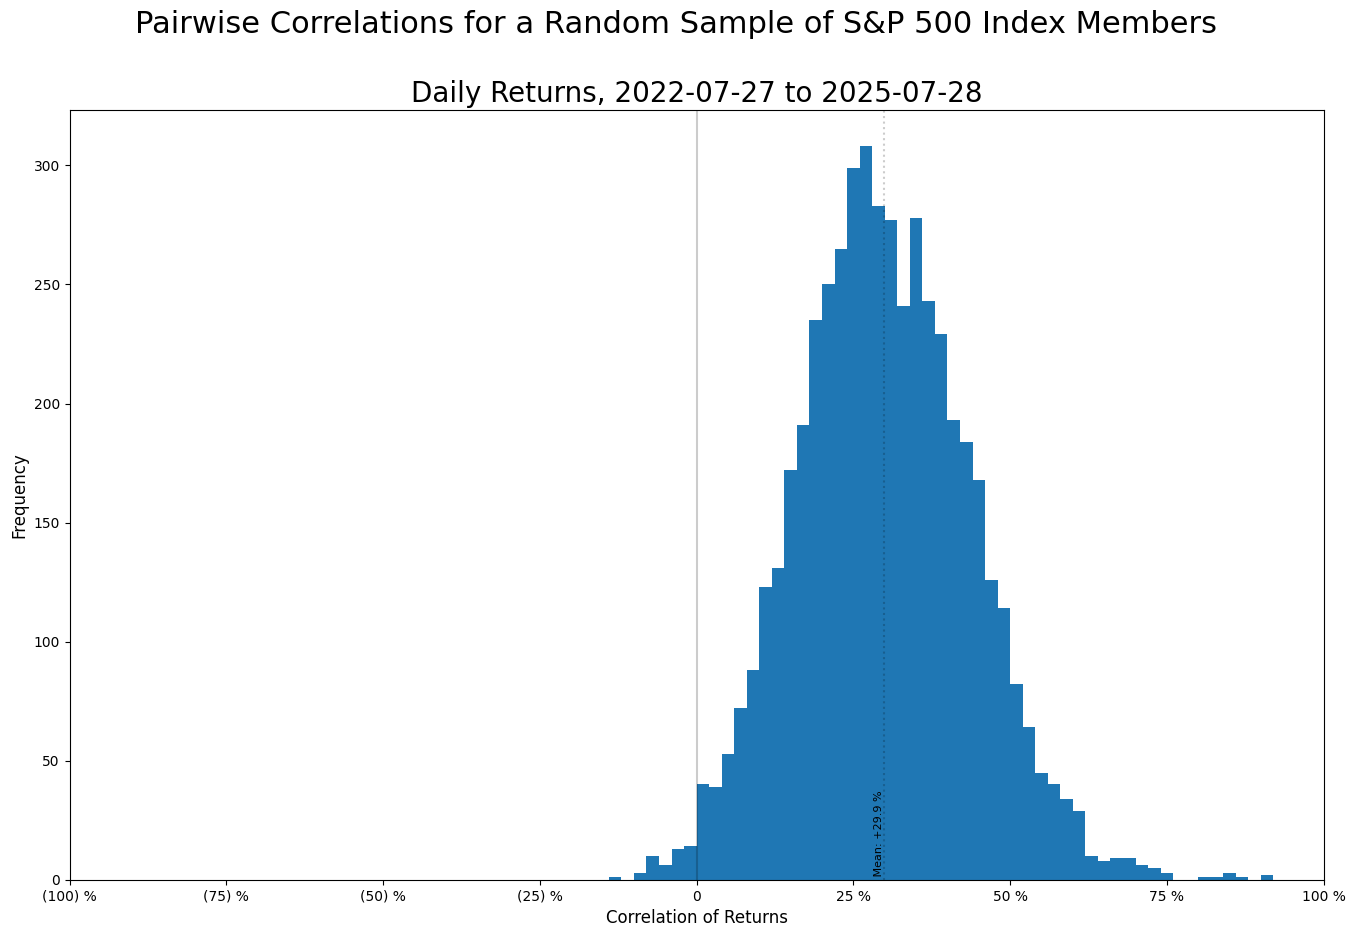

In [ ]:
figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
counts,bins,patches=plot.hist(results.loc[results.index!="Mean",'Correlation'].to_numpy(),bins=np.linspace(-hundred,hundred,101))
figure.suptitle(title:="Pairwise Correlations for a Random Sample of %s Index Members" % indexname,fontsize=22)
plot.set_title(subtitle:="Daily Returns, %s to %s" % (first_date,today("%Y-%m-%d")),fontsize=20)
plot.set_xlabel("Correlation of Returns",fontsize=12)
plot.xaxis.set_major_formatter(PercentLabels(0))
plot.set_ylabel("Frequency",fontsize=12)
plot.yaxis.set_major_formatter(CountLabels())
plot.axvline(m,color='black',alpha=0.2,linestyle=':')
plot.text(m,zero,' Mean: %+4.1f %%' % m,fontsize=8,ha='right',va='bottom',rotation=90)
plot.axvline(zero,color='black',alpha=0.2)
plot.set_xlim(-hundred,hundred)
figure.savefig(title+".png",dpi=300,bbox_inches='tight')

### Execute the $N^*$ vs. $N$ Analysis
---
$N^*$ is the effective degrees of freedom found within a portfolio of size $N$. This is computed by comparing the variance of the portfolio returns to the variance we would expect if all the stocks were independent.

In [ ]:
results=pd.DataFrame({"Sample":range(1,(n:=5000)+1),"Assets":[np.nan]*n,"Portfolio":[np.nan]*n,"Stocks":[""]*n}).set_index("Sample") # n is number of trials
nprint("Getting daily data for all index stocks, starting on %s." % first_date)
closes=data['Close']
closes.index=pd.DatetimeIndex(closes.index).to_period('B')

nprint("Beginning analysis for {:,d} trials (total number of portfolios is around 10**{:f}).".format(n,index.shape[0]*np.log(two)/np.log(ten)))

for i in tqdm(results.index): # for each trial, pick a random sample of stocks with portfolio sizes uniformly distributed between 1 and maximum, one of 2^503-1 choices
    returns=pd.DataFrame()

    for ticker in closes[generator.choice(closes.columns,generator.integers(1,closes.shape[1]+1),replace=False)]:
        returns[ticker]=closes[ticker].pct_change().dropna()*hundred # compute all adjusted returns, ticker by ticker

        if indexname=='FTSE 250':
            returns[ticker][(returns[ticker]<-return_filter)|(returns[ticker]>return_filter)]=np.nan # filter out returns that are caused by scaling errors in FTSE data

        if returns[ticker].count()<ten: # exclude time-series with very little data
            returns.drop(columns=ticker,inplace=True)

        else:
            returns=returns.copy() # 'cos it frags, apparently

    returns.dropna(inplace=True)
    results.loc[i,"Stocks"]=",".join(sorted(returns.columns)) # list of stocks in portfolio
    returns.drop(returns.index[-1],inplace=True) # get rid of final print in case unprocessed corporate actions exist
    returns['Portfolio']=returns.mean(axis=1) # equal weighted portfolio return
    results.loc[i,"Assets"]=returns.shape[1]-1 # number of assets we ended up with
    results.loc[i,"Independent"]=returns[list(set(returns.columns).difference("Portfolio"))].var().sum()/results.loc[i,"Assets"]**2 # if no correlation, portfolio variance is total variance divided by square of number of assets
    results.loc[i,"Portfolio"]=returns['Portfolio'].var() # variance of portfolio returns for same period as individual returns

results.dropna(inplace=True)
results.drop_duplicates(inplace=True)
results["Effective D.o.F."]=results["Independent"]/results["Portfolio"]*results["Assets"]
display(results)
nprint("Done.")

12:30:17 Getting daily data for all index stocks, starting on 2022-07-27.
12:30:17 Beginning analysis for 5,000 trials (total number of portfolios is around 10**151.418088).


  0%|          | 0/5000 [00:00<?, ?it/s]

,Assets,Portfolio,Stocks,Independent,Effective D.o.F.
Sample,,,,,
1,381.0,1.056166,"A,AAPL,ABBV,ABNB,ABT,ADBE,ADI,ADSK,AEE,AEP,AIG...",0.011264,4.063304
2,229.0,1.060368,"A,ABT,ADP,ADSK,AEP,AFL,AIG,AIZ,AKAM,AMAT,AMD,A...",0.019347,4.178194
3,10.0,1.384654,"BLDR,COP,CTAS,KLAC,MKTX,PNC,TECH,TKO,TT,WMT",0.440526,3.181489
4,371.0,1.092524,"ABBV,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,ADSK,AEP,AE...",0.011638,3.951926
5,359.0,1.071031,"A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADP,AEE,AEP...",0.012213,4.093716
...,...,...,...,...,...
4996,155.0,1.140389,"ADBE,ADM,ADP,AEP,AFL,AIG,AIZ,AJG,AON,APD,AVY,A...",0.029944,4.069953
4997,23.0,1.019731,"AAPL,AIZ,AOS,CAG,ELV,EPAM,FFIV,GIS,HCA,HPQ,IRM...",0.159512,3.597796
4998,44.0,0.797034,"AEE,AFL,ALL,ARE,BALL,CHD,COP,CSX,CTAS,CVX,DASH...",0.071639,3.954797


13:07:19 Done.


### Fit a Linear Model to $N^*(N)$

In [ ]:
from statsmodels.api import OLS,add_constant
design=results[select:=(results["Assets"]>=(Nmin:=two))&(results["Assets"]<=(Nmax:=results["Assets"].max()-one))][[yn:="Effective D.o.F.",xn:="Assets"]].drop_duplicates()
model=OLS(design[yn],add_constant(design[xn])).fit()
nprint(model.summary())
nprint("Implied regression factor count: {:.2f} +/- {:.2g} for data in [{:,.0f},{:,.0f}].".format(Kreg:=one/model.params[1],model.bse[1]/model.params[1]**4,Nmin,Nmax))
final=results[results[xn]==results[xn].max()].drop_duplicates(xn)
Nstar,Nact=tuple(final.iloc[-1][[yn,xn]])
rho=(Nact-Nstar)/((Nact-one)*Nstar)
Khat=Nact/Nstar
nprint("Linear Factor Model: Implied limiting factor count: {:.0f}.".format(Khat))
nprint("Isotropic Correlation: Effective D.o.F. Limit {:,.2f}, Implied Correlation {:.2f} %.".format(Nstar,rho*hundred))

13:07:20                             OLS Regression Results                            
Dep. Variable:       Effective D.o.F.   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     979.4
Date:                Mon, 28 Jul 2025   Prob (F-statistic):          1.94e-196
Time:                        13:07:20   Log-Likelihood:                -1082.6
No. Observations:                4982   AIC:                             2169.
Df Residuals:                    4980   BIC:                             2182.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.7261      0.009    436.095

### Fit a Non-Linear Model to $N^*(N)$ (with linear constraints)

In [ ]:
from scipy.optimize import minimize,LinearConstraint
from scipy.differentiate import hessian

def residuals(theta):
    """Residuals to edof."""
    bb2,b2b,s2b=tuple(theta)
    return design[yn]-design[xn].apply(lambda x:edof(x,bb2,b2b,s2b))

def hrss(theta):
    """Half of the residual sum of squares, so it looks like a log-likelihood minimizer for computing the Fisher Information."""
    return half*(residuals(theta)**two).sum()

fit=minimize(hrss,[one,one,one],constraints=LinearConstraint(np.array([[one,zero,zero],[zero,one,zero],[zero,zero,one],[-one/Nmax,one,zero]]),zero,np.inf),method='trust-constr')
theta,sigma=fit.x,(-np.linalg.inv(hessian(rss,fit.x).ddf)*(two*hrss(fit.x))/(residuals(fit.x).count()-len(fit.x)))**half
nprint("""Scalar parameters fitted by Constrained Non-Linear Least Squares:

Variable  Estimate  Std.Err.   t Score   p Value
------------------------------------------------
b-bar^2  %9.4g %9.4g %9.4g %9.7g
b^2 bar  %9.4g %9.4g %9.4g %9.7g
s^2 bar  %9.4g %9.4g %9.4g %9.7g
================================================
""" % tuple(np.array(list(zip(theta,np.sqrt(np.diag(sigma)),Z:=theta/np.sqrt(np.diag(sigma)),two*norm.sf(Z)))).flatten()))
nprint("Asympotic Number of Linear Factors:",Khat:=theta[1]/theta[0],'±',Khat*(sigma[0][0]/theta[0]**two+sigma[1][1]/theta[1]**2)**half)

15:27:00 Scalar parameters fitted by Constraint Non-Linear Least Squares:

Variable  Estimate  Std.Err.   t Score   p Value
------------------------------------------------
b-bar^2     0.7861    0.1223     6.429 1.285488e-10
b^2 bar   0.001566  0.007218    0.2169 0.8282534
s^2 bar      2.802    0.2098     13.36 1.09909e-40

15:27:00 Asympotic Number of Linear Factors: 0.001992032775604465 ± 0.009187545546901061


### Make a Plot

15:12:46 Wrote figure to /content/drive/MyDrive/Relationship between Equal Weighted Portfolio Size and Effective D.o.F..png.


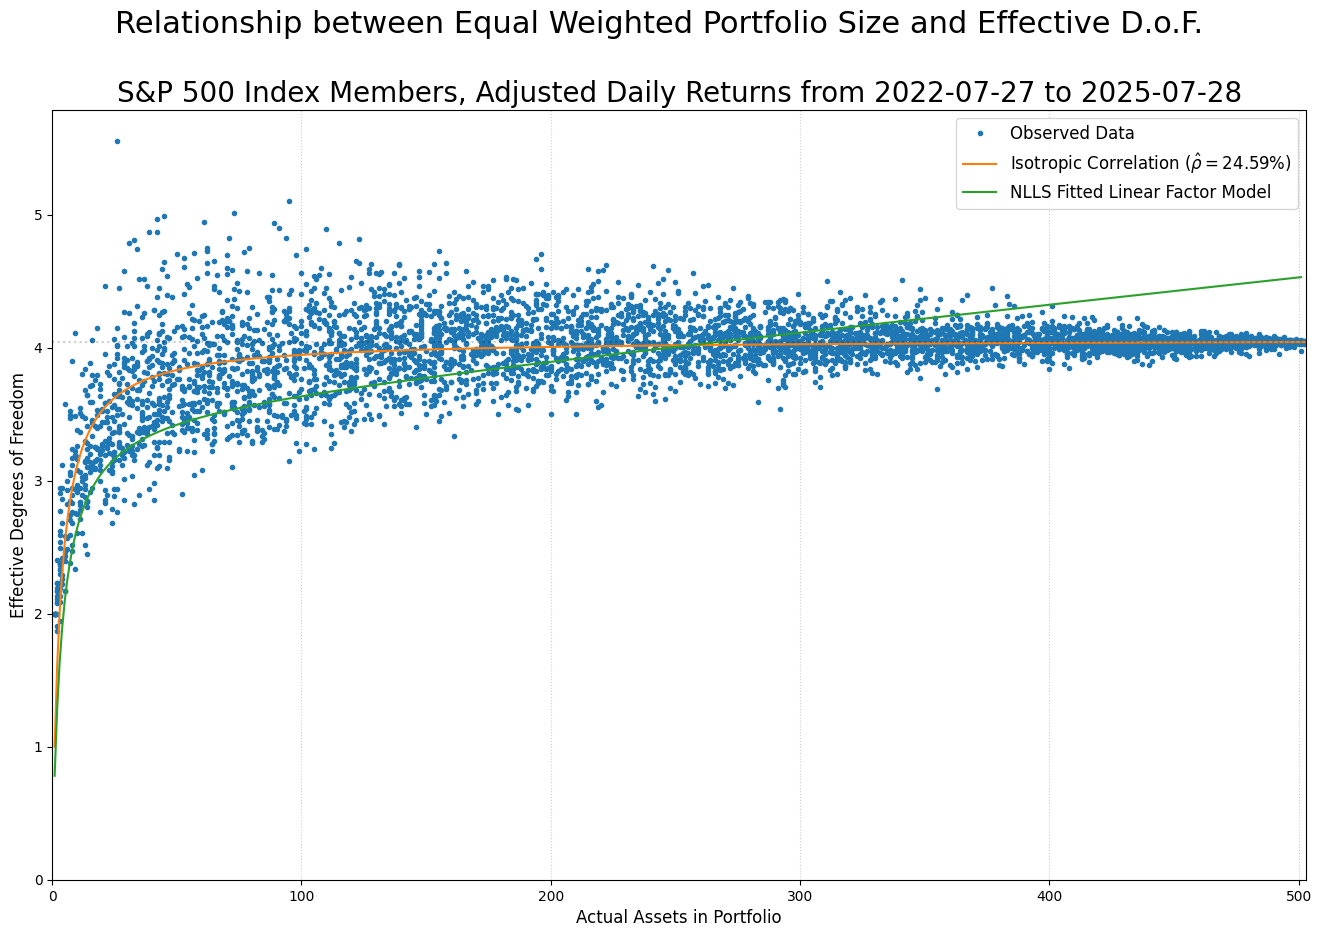

In [ ]:
figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
plot.plot(x:=results["Assets"].to_numpy(),y:=results["Effective D.o.F."].to_numpy(),'.',label='Observed Data')
plot.plot(xp:=np.append([] if max(x)>100 else [zero],np.unique(np.sort(x))),xp/(one+(xp-one)*rho),'-',label='Isotropic Correlation ($\\hat{\\rho} = %.2f$%%)' % (rho*hundred))
plot.plot(xpp:=np.arange(one,Nmax,one),ypp:=np.vectorize(edof)(xpp,*theta),'-',label="NLLS Fitted Linear Factor Model")
#plot.set_xscale('log' if max(x)>100 else 'linear')
plot.set_ylim(zero,None)
plot.set_xlabel("Actual Assets in Portfolio",fontsize=12)
plot.set_ylabel("Effective Degrees of Freedom",fontsize=12)
figure.suptitle(title:="Relationship between Equal Weighted Portfolio Size and Effective D.o.F.",fontsize=22)
plot.set_title(subtitle:="%s Index Members, Adjusted Daily Returns from %s to %s" % (indexname,first_date,pd.Timestamp.today().strftime("%Y-%m-%d")),fontsize=20)
plot.set_xlim(zero,index.shape[0])
plot.legend(fontsize=12)
plot.axhline(Nstar,color='black',linestyle=':',alpha=0.2)
plot.xaxis.set_major_formatter(CountLabels())
plot.grid(which='both',axis='x',linestyle=':',color='black',alpha=0.2)
figure.savefig(filename:='/content/drive/MyDrive/'+title+".png",dpi=300,bbox_inches='tight')
nprint("Wrote figure to %s." % filename)

### Meta-Analysis
---

In [ ]:
from scipy.stats import chi2,f as fdensity
meta=pd.DataFrame()
meta["Mean"]=(g:=results[(results["Assets"]<=Nmax)][["Assets","Effective D.o.F."]].groupby("Assets")).mean()
meta["St.Dev."]=g.std()
meta["Sample"]=g.count()
meta["Std.Err."]=meta["St.Dev."]/meta["Sample"]**0.5
meta[(l:="Isotropic","Model")]=(x:=meta.index)/(one+(x-one)*rho)
meta[(l,"Error")]=meta["Mean"]-meta[(l,"Model")]
meta[(l,"Z Score")]=meta[(l,"Error")]/meta["Std.Err."]
meta[(l,"Chi Sq.")]=meta[(l,"Z Score")]**2
meta.replace(np.inf,np.nan,inplace=True)
nprint("%s Model: Total Chi Squared %g for %d d.o.f., p Value = %g." % (l,sc21:=meta[(l,"Chi Sq.")].sum(),df1:=meta[(l,'Chi Sq.')].count(),chi2(df1).sf(sc21)))
meta[(l:="Factor","Model")]=list(map(lambda x:edof(x,*theta) if x>=Nmin and x<=Nmax else np.nan,meta.index))
meta[(l,"Error")]=meta["Mean"]-meta[(l,"Model")]
meta[(l,"Z Score")]=meta[(l,"Error")]/meta["Std.Err."]
meta[(l,"Chi Sq.")]=meta[(l,"Z Score")]**2
nprint("%s Model: Total Chi Squared %g for %d d.o.f., p Value = %g." % (l,sc22:=meta[(l,"Chi Sq.")].sum(),df2:=meta[(l,'Chi Sq.')].count(),chi2(df2).sf(sc22)))
fstat=(sc22/df2)/(sc21/df1)
nprint("F-Statistic %g with two sided p Value %g." % (fstat,two*min([fdensity(df1,df2).sf(fstat),fdensity(df1,df2).cdf(fstat)])))
meta.columns=pd.MultiIndex.from_tuples(list(map(lambda x:x if type(x)==tuple else (x,''),meta.columns)))
display(meta)

15:13:52 Isotropic Model: Total Chi Squared 1011.24 for 501 d.o.f., p Value = 9.99063e-37.
15:13:52 Factor Model: Total Chi Squared 276734 for 501 d.o.f., p Value = 0.
15:13:52 F-Statistic 273.658 with two sided p Value 0.


Mean   St.Dev. Sample  Std.Err. Isotropic                       \
                                                Model     Error    Z Score   
Assets                                                                       
1.0     2.000000  0.000000      8  0.000000  1.000000  1.000000        NaN   
2.0     2.120921  0.142270     13  0.039459  1.605262  0.515659  13.068385   
3.0     2.416949  0.265164     19  0.060833  2.010987  0.405962   6.673412   
4.0     2.599403  0.349268      8  0.123485  2.301883  0.297520   2.409364   
5.0     2.535543  0.446348      8  0.157808  2.520657  0.014886   0.094330   
...          ...       ...    ...       ...       ...       ...        ...   
498.0   4.033666  0.015428     12  0.004454  4.041763 -0.008097  -1.817957   
499.0   4.048338  0.008688     15  0.002243  4.041812  0.006525   2.908814   
500.0   4.043307  0.009364      8  0.003311  4.041862  0.001445   0.436470   
501.0   4.037324  0.020602     12  0.005947  4.041911 -0.004587  -0.771208   
502.0   4.041144  0.011110      4  0.005555  4.041960 -0.000816  -0.146887   

                      Factor                                      
           Chi Sq.     Model     Error     Z Score       Chi Sq.  
Assets                                                            
1.0            NaN       NaN       NaN         NaN           NaN  
2.0     170.782688  1.282532  0.838390   21.247359    451.450252  
3.0      44.534425  1.631627  0.785321   12.909516    166.655601  
4.0       5.805034  1.888946  0.710458    5.753396     33.101567  
5.0       0.008898  2.086636  0.448906    2.844635      8.091948  
...            ...       ...       ...         ...           ...  
498.0     3.304968  4.523710 -0.490044 -110.030327  12106.672927  
499.0     8.461202  4.525753 -0.477415 -212.814819  45290.147096  
500.0     0.190506  4.527795 -0.484488 -146.336850  21414.473687  
501.0     0.594763  4.529837 -0.492512  -82.813937   6858.148166  
502.0     0.021576  4.531878 -0.490734  -88.338306   7803.656245  

[502 rows x 12 columns]

15:13:57 Wrote figure to /content/drive/MyDrive/Relationship between Equal Weighted Portfolio Size and Effective D.o.F. 2.png.


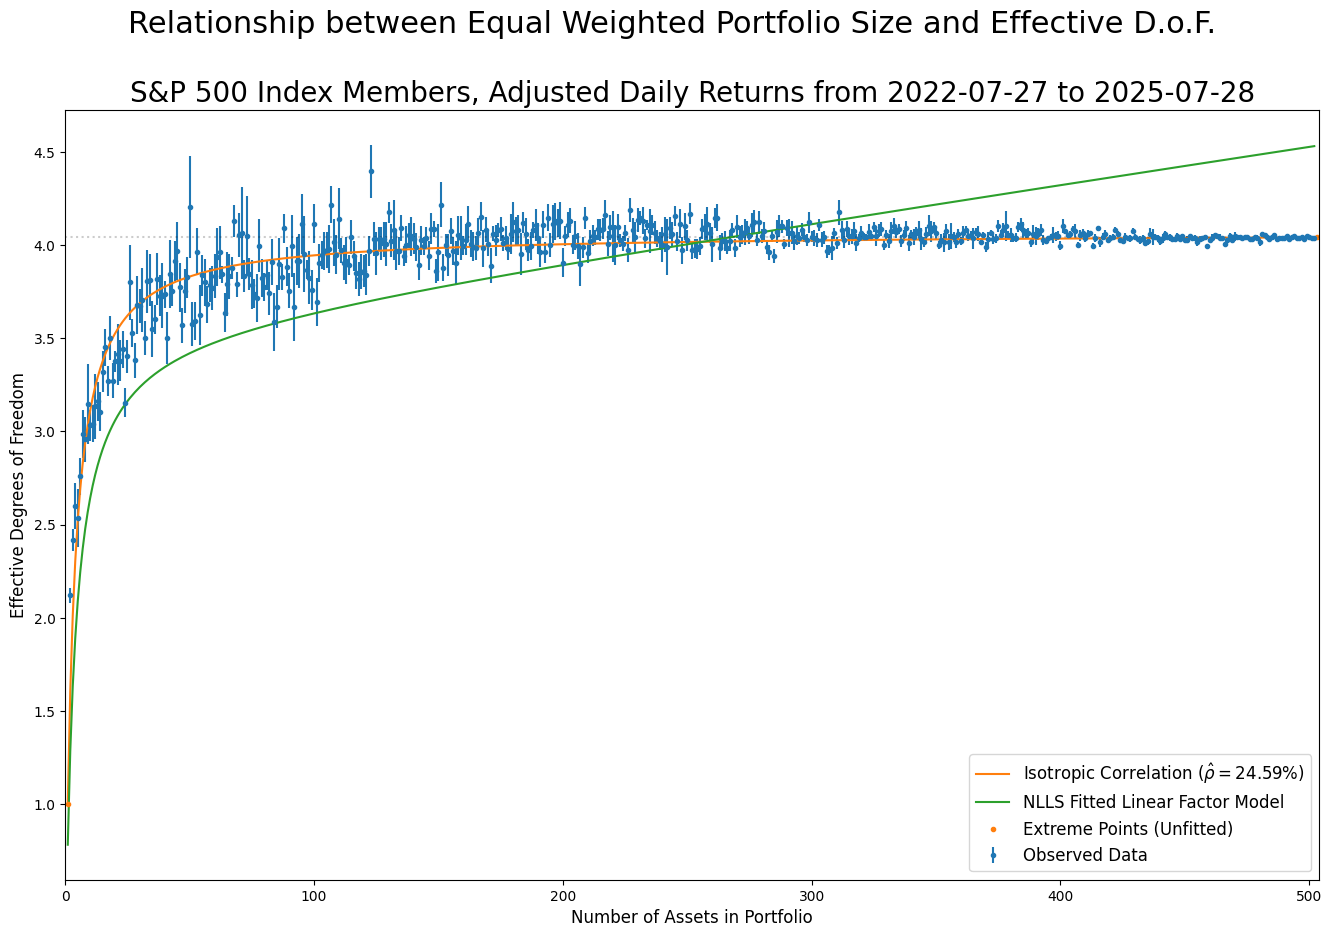

In [ ]:
figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
plot.errorbar(x:=meta.index[1:],y:=meta.loc[x,"Mean"],yerr=meta.loc[x,"Std.Err."],fmt='.',label='Observed Data',color='C0')
plot.plot(x:=meta.index,z:=meta[("Isotropic","Model")],'-',label='Isotropic Correlation ($\\hat{\\rho} = %.2f$%%)' % (rho*hundred),color='C1')
plot.plot(xp:=np.arange(one,Nmax+one),np.vectorize(edof)(xp,*theta),'-',label="NLLS Fitted Linear Factor Model",color='C2')
plot.plot([one,Nact],[one,Nstar],'.',label='Extreme Points (Unfitted)',color='C1')
plot.set_xlabel("Number of Assets in Portfolio",fontsize=12)
plot.set_ylabel("Effective Degrees of Freedom",fontsize=12)
figure.suptitle(title,fontsize=22)
plot.set_title(subtitle,fontsize=20)
plot.set_xlim(zero,Nmax+two)
plot.legend(fontsize=12)
plot.axhline(Nstar,color='black',linestyle=':',alpha=0.2)
plot.xaxis.set_major_formatter(CountLabels())
figure.savefig(filename:="/content/drive/MyDrive/"+title+" 2.png",dpi=300,bbox_inches='tight')
nprint("Wrote figure to %s." % filename)